In [26]:
# Install the required packages
# %pip install --upgrade pip
# %pip install -q langgraph langchain_openai langchain_huggingface
# %pip install pandas -q

## Setting Up Our Environment

First, let's import all the necessary libraries. LangGraph provides the graph structure, while LangChain offers convenient interfaces for working with LLMs.

In [ ]:
import os
import pandas as pd
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

# Set your OpenAI API key here
# os.environ["OPENAI_API_KEY"] = "sk-...."  # Replace with your actual API key

# Initialize our LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

## Step 1: Define Our State

In LangGraph, **State** is the central concept. It represents all the information that flows through our workflow.

In [28]:
class EmailState(TypedDict):
    email: Dict[str, Any]           
    is_spam: Optional[bool]         
    spam_reason: Optional[str]      
    email_category: Optional[str]   
    draft_response: Optional[str]   
    messages: List[Dict[str, Any]]  

In [29]:
class MetricState(TypedDict):
    metric_name: str
    metric_usage: pd.DataFrame
    is_concern: Optional[bool]
    last_1day_average: int
    last_7days_average: int
    last_30days_average: int
    last_90days_average: int
    last_180days_average: int
    last_365days_average: int
    threshold: Optional[int]


## Step 2: Define Our Nodes

In [30]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

# Initialize LLM
model = ChatOpenAI( model="gpt-4o",temperature=0)


# Define nodes
def process_metric(state: MetricState):
    metric_name = state["metric_name"]
    metric_usage = state["metric_usage"]
    print(metric_name)
    return {}

def classify_concern(state: MetricState):
    print(f"is_concern is processing")
    metric_name = state["metric_name"]
    metric_usage = state["metric_usage"]  

    prompt = f"""
        As an AI assistant, analyze the metric usage data for {metric_name} and determine if there is a concern.
        The usage data for {metric_name} is {metric_usage}
        The metric usage is available as pandas dataframe which has time and value columns.
        answer with YES or NO if there is a concern. Only return the answer and explanation
        Answer :
        Explanation :
    """
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    response_text = response.content.lower()
    is_concern = "yes" in response_text.split('\n')[0] and "no" not in response_text.split('\n')[0]
    print("Response: \n", response_text)
    print("Is this a concern: ", is_concern)
    return {is_concern: is_concern}


# Create the graph
metric_graph = StateGraph(MetricState)
# Add nodes
metric_graph.add_node("process_metric", process_metric)
metric_graph.add_node("classify_concern", classify_concern)

## Step 3: Define Our Routing Logic

In [31]:
# Add edges
metric_graph.add_edge(START, "process_metric")
metric_graph.add_edge("process_metric", "classify_concern")
# Add conditional edges
# email_graph.add_conditional_edges(
#     "classify_email", # after classify, we run the "route_email" function"
#     route_email,
#     {
#         "spam": "handle_spam", # if it return "Spam", we go the "handle_span" node
#         "legitimate": "drafting_response" # and if it's legitimate, we go to the "drafting response" node
#     }
# )

# Add final edges
# metric_graph.add_edge("process_metric", END)
metric_graph.add_edge("classify_concern", END)

## Step 4: Create the StateGraph and Define Edges

In [32]:
compiled_metric_graph = metric_graph.compile()

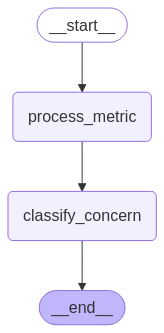

In [33]:
from IPython.display import Image, display

display(Image(compiled_metric_graph.get_graph().draw_mermaid_png()))

In [41]:
metric_usage = pd.read_csv("disk_usage.csv")
metric_state = MetricState(
    metric_name="disk_usage",
    metric_usage=metric_usage,
    is_concern=None,
    last_1day_average=0,
    last_7days_average=0,
    last_30days_average=0,
    last_90days_average=0,
    last_180days_average=0,
    last_365days_average=0,
    threshold=None
)


processed_result = compiled_metric_graph.invoke(metric_state)

disk_usage
is_concern is processing
Response: 
 answer: yes

explanation: the disk usage values are consistently high, with the initial value at 84.4% and the final value at 76.4%. although there is a slight decrease over time, the usage remains above 75% throughout the period. high disk usage can lead to performance issues, lack of space for new data, and potential system failures if not addressed. it is advisable to monitor the situation closely and consider freeing up space or expanding disk capacity to prevent potential problems.
Is this a concern:  True


#Integrating with Local model
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage

# Custom class for local model
class LocalModel:
    def __init__(self, model_name: str):
        self.model_name = model_name
        # Initialize your local model here

    def invoke(self, messages: List[HumanMessage]) -> AIMessage:
        # Implement the logic to interact with your local model
        # For example, sending the prompt to the local model and getting the response
        prompt = messages[0].content
        response_text = self.generate_response(prompt)
        return AIMessage(content=response_text)

    def generate_response(self, prompt: str) -> str:
        # Replace this with the actual interaction with your local model
        # For example, using subprocess to call a local script or API
        return "yes\nExplanation: This is a sample response from the local model."

# Initialize local model
model = LocalModel(model_name="gemma3")

# Define nodes
def process_metric(state: MetricState):
    metric_name = state["metric_name"]
    metric_usage = state["metric_usage"]
    print(metric_name)
    return {}

def classify_concern(state: MetricState):
    print(f"is_concern is processing")
    metric_name = state["metric_name"]
    metric_usage = state["metric_usage"]  

    prompt = f"""
        As an AI assistant, analyze the metric usage data for {metric_name} and determine if there is a concern.
        The usage data for {metric_name} is {metric_usage}
        The metric usage is available as pandas dataframe which has time and value columns.
        answer with YES or NO if there is a concern. Only return the answer and explanation
        Answer :
        Explanation :
    """
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    response_text = response.content.lower()
    is_concern = "yes" in response_text.split('\n')[0] and "no" not in response_text.split('\n')[0]
    print("Response: \n", response_text)
    print("Is this a concern: ", is_concern)
    return {is_concern: is_concern}

# Create the graph
# metric_graph = StateGraph(MetricState)
# Add nodes
# metric_graph.add_node("process_metric", process_metric)
# metric_graph.add_node("classify_concern", classify_concern)

In [35]:
metric_usage = pd.read_csv("disk_usage.csv")
metric_state = MetricState(
    metric_name="disk_usage",
    metric_usage=metric_usage,
    is_concern=None,
    last_1day_average=0,
    last_7days_average=0,
    last_30days_average=0,
    last_90days_average=0,
    last_180days_average=0,
    last_365days_average=0,
    threshold=None
)


processed_result = compiled_metric_graph.invoke(metric_state)

disk_usage
is_concern is processing
Response: 
 answer: yes

explanation: the disk usage values are consistently high, with the initial value at 84.4% and the final value at 76.4%. although there is a slight decrease over time, the usage remains above 75% throughout the period. high disk usage can lead to performance issues, such as slower read/write speeds and potential system instability. it is generally recommended to maintain disk usage below 70-80% to ensure optimal performance and to allow room for growth and temporary spikes in usage. therefore, the consistently high usage indicates a potential concern that should be addressed.
Is this a concern:  True
